In [143]:
import matplotlib.pyplot as plt
import numpy as np
import requests
import csv
import pandas as pd
import requests
import json
import http
import io
import datetime
import statsmodels.api as sm
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, balanced_accuracy_score

Name of variables from LOBO: 
- Chemical composition: cdom, conductivity, oxygen,  nitrate, oxygen_sat, salinity, phosphate, pH  
- Physical properties: flourescence, voltage, temperature, turbidity, scattering
- Biological properties: chlorophyll
- Others: depth, temperature, pressure, current_direction

In [2]:
"""
The function below is used for requesting LOBO dataset.
The input of the function is: min_date, max_date, node (by default of "68" - SLE-SF2 station), list of variables (y)
"""
def LOBORequest(min_date, max_date, node, y):
    link = f"http://fau.loboviz.com/cgi-data/nph-data.cgi?min_date={min_date}&max_date={max_date}&y={y}&data_format=text&node={node}"
    receive = requests.get(link)
    
    #Translate the text file (above) into a dataframe
    url_data = receive.content
    file = io.StringIO(url_data.decode('utf-8'))
    
    raw_data = []
    for x in file:
        raw_data.append(x)

    raw_data = [n.replace('\n', '') for n in raw_data]
    raw_data = [n.split('\t') for n in raw_data]

    raw_dataframe = {}
    pdSeries = []

    for index, item in enumerate(raw_data):
        if index == 2:
            for variable in item: 
                raw_dataframe.update({variable:{}})

        final_dataframe = pd.DataFrame(raw_dataframe)
        if index >= 3:
            for index2, value in enumerate(item):
                if index2 == 0: 
                    #Transfer the first text value into date time value
                    item[index2] = datetime.datetime.strptime(value, '%Y-%m-%d %H:%M:%S')

                if index2 != 0:
                    #Transfer text to float, for example "24.89" to 24.89
                    if value != '' and value.count(".")<2:
                        item[index2] = float(value)
                        if float(value) < 0:
                            item[index2] = None
                    else:
                        item[index2] = None

            pdSeries.append(pd.Series(item, index=final_dataframe.columns))
        
    final_dataframe = final_dataframe.append(pdSeries, ignore_index = True)
    #Some date values will show weird integer values, for example in 2018 dataset, at row 903.
    #We want to remove those rows from our dataset
    removed_rows = []
    for index, date in enumerate(final_dataframe['date [EST]']):
        if type(date) == int:
            removed_rows.append(index)
    final_dataframe = final_dataframe.drop(removed_rows)
    return final_dataframe

In [3]:
dataset = LOBORequest(min_date = "20170101" , max_date = "20191231", node = "68", y = "temperature, chlorophyll, cdom, phosphate, nitrate, oxygen, salinity, current_speed")

In [4]:
dataset

,date [EST],temperature [C],chlorophyll [ug/L],CDOM [QSDE],phosphate concentration [uM],nitrate [uM],dissolved oxygen [ml/l],salinity [PSU],current speed [mm/s]
0,2017-01-01 00:00:00,23.51,4.21,53.18,2.25,16.8,1.32,14.80,55.2
1,2017-01-01 01:00:00,23.62,4.26,52.45,1.97,13.4,1.06,14.92,76.1
2,2017-01-01 02:00:00,23.65,6.11,52.31,1.87,12.3,0.98,14.91,45.3
3,2017-01-01 03:00:00,23.61,5.19,51.62,1.70,15.9,0.88,14.97,74.3
4,2017-01-01 04:00:00,23.49,4.63,51.97,1.55,15.0,1.09,15.00,46.9
...,...,...,...,...,...,...,...,...,...
25949,2019-12-31 19:00:00,23.49,3.60,30.35,8.64,79.8,4.72,0.39,26.0
25950,2019-12-31 20:00:00,23.46,3.79,30.32,8.52,74.8,4.77,0.39,45.5
25951,2019-12-31 21:00:00,23.38,3.71,30.48,8.40,75.0,4.74,0.39,57.0
25952,2019-12-31 22:00:00,23.30,3.50,30.70,8.30,74.2,4.53,0.40,3.0


In [5]:
dataset["new date"] = list(map(lambda date: date.timetuple().tm_yday,
                               dataset["date [EST]"]))

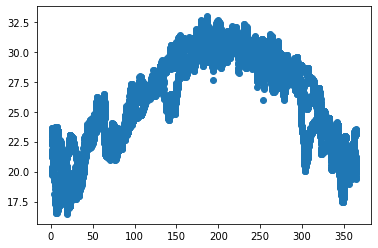

In [6]:
plt.scatter(dataset["new date"], dataset["temperature [C]"])
plt.show()

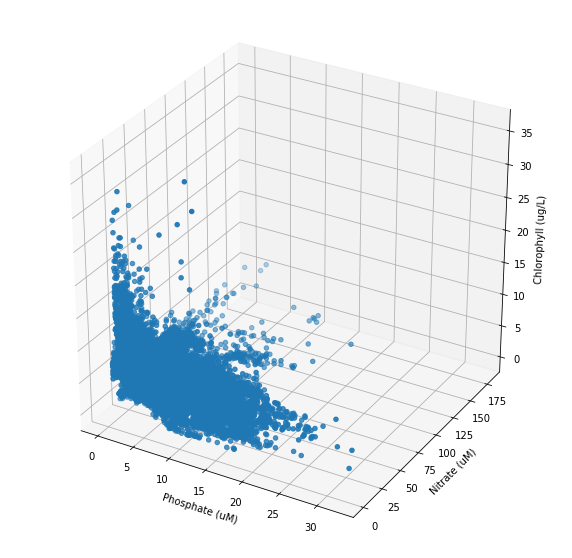

In [7]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dataset["phosphate concentration [uM]"], dataset["nitrate [uM]"], dataset["chlorophyll [ug/L]"])
ax.set_xlabel('Phosphate (uM)')
ax.set_ylabel('Nitrate (uM)')
ax.set_zlabel('Chlorophyll (ug/L)')
plt.show()

In [8]:
dataset.columns

Index(['date [EST]', 'temperature [C]', 'chlorophyll [ug/L]', 'CDOM [QSDE]',
       'phosphate concentration [uM]', 'nitrate [uM]',
       'dissolved oxygen [ml/l]', 'salinity [PSU]', 'current speed [mm/s]',
       'new date'],
      dtype='object')

In [9]:
dataset = dataset[['CDOM [QSDE]', 'phosphate concentration [uM]', 'nitrate [uM]', 'temperature [C]','chlorophyll [ug/L]']].dropna()

In [10]:
X = dataset[['CDOM [QSDE]', 'phosphate concentration [uM]', 'nitrate [uM]', 'temperature [C]']]
y = dataset['chlorophyll [ug/L]']

In [11]:
from sklearn.linear_model import LinearRegression

In [15]:
reg = LinearRegression().fit(X,y)
reg.score(X,y)

0.20792257473339082

In [13]:
reg.coef_

array([ 0.06926667, -0.02529069, -0.04125473, -0.09343384])

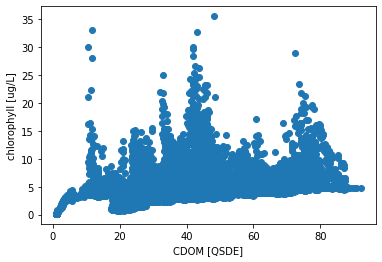

In [14]:
x_title = "CDOM [QSDE]"
y_title = "chlorophyll [ug/L]"
plt.scatter(dataset[x_title], dataset[y_title])
plt.xlabel(x_title) 
plt.ylabel(y_title)
plt.show()

In [91]:
dataset = LOBORequest(min_date = "20170101" , max_date = "20201001", node = "68", y = "temperature, chlorophyll, cdom, phosphate, nitrate, oxygen, salinity, current_speed")

In [92]:
dataset.rename(columns={"CDOM [QSDE]": "cdom", 
                        "phosphate concentration [uM]": "phosphate", 
                        "nitrate [uM]": "nitrate",
                       "temperature [C]": "temperature",
                       "chlorophyll [ug/L]": "chlorophyll", 
                       "date [EST]": "date",
                        "dissolved oxygen [ml/l]": "oxygen",  
                       "temperature [C]": "temperature"}, 
               inplace = True)

In [84]:
dataset2 = dataset[["cdom", "phosphate", "nitrate", "temperature", "chlorophyll"]].dropna()

In [140]:
predictor = ["cdom", "phosphate", "nitrate", "temperature"]
clf_score = []

X = dataset2[predictor]

for threshold in [20]:
    y = dataset2["chlorophyll"] >= threshold
    if np.sum(y) == 0 or np.sum(y) == 0:
        clf_score.append(np.nan)
    else:
        clf = LogisticRegression().fit(X,y)
        y_pred = clf.predict(X)
        if np.sum(y_pred) == 1 or np.sum(y_pred) == 0:
            ROC_AUC_score = np.nan
        else:
            ROC_AUC_score = roc_auc_score(y_pred, y)
        clf_score.append([accuracy_score(y_pred,y),
                          precision_score(y_pred,y),
                          recall_score(y_pred, y),
                          ROC_AUC_score,
                         balanced_accuracy_score(y_pred,y)])

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1745: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


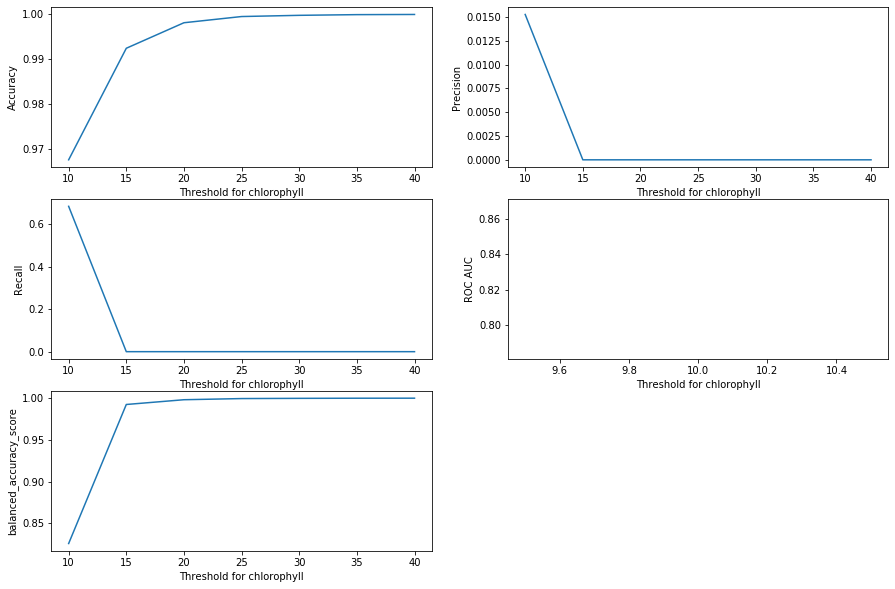

In [86]:
fig = plt.figure(figsize=(15,10))
for i, label in zip(range(5), ["Accuracy","Precision","Recall","ROC AUC", "balanced_accuracy_score"]):
    ax = fig.add_subplot(3,2,i+1)
    ax.plot(range(10,41,5), [x[i] for x in clf_score])
    ax.set(ylabel=label, xlabel="Threshold for chlorophyll")

In [137]:
X = dataset[predictor]
threshold = 20
y = dataset["chlorophyll"] >= threshold
clf = LogisticRegression()
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
cross_val_score(clf, X, y, cv=cv)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:530: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [78]:
clf.fit(X,y)
clf.coef_

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([[ 0.00884874, -0.18768624, -0.09129607, -0.25317568]])

Linear Regression:

In [148]:
predictor = ['cdom', 'phosphate', 'nitrate', 'temperature']
coef_result = []
score_result = []

for day_shift in [0,1,2,3]:
    delta = datetime.timedelta(days=day_shift)
    correct_chl = []
    for i in dataset.index:
        current_time = dataset["date"][i]
        next_time = current_time + delta
        next_value = dataset.loc[dataset["date"]==next_time,"chlorophyll"].values
        if len(next_value) == 1:
            correct_chl.append(next_value[0])
        else:
            correct_chl.append(np.nan)
     
    dataset["Correct Chl"] = correct_chl
    dataset3 = dataset[predictor+["Correct Chl"]].dropna()
    X = dataset3[predictor]
    y = dataset3["Correct Chl"]
    reg = LinearRegression().fit(X,y)
    coef_result.append(reg.coef_)
    score_result.append(reg.score(X,y))

In [152]:
coef_result

[array([ 0.07380843, -0.0090871 , -0.03990354, -0.08316725]),
 array([ 0.07437792,  0.00318131, -0.03730066, -0.09093117]),
 array([ 0.07297277,  0.00694756, -0.03470422, -0.09118881]),
 array([ 0.07170784,  0.00729311, -0.03375036, -0.09015318])]

In [145]:
predictor = ['cdom', 'phosphate', 'nitrate']
coef_result_1 = []
score_result_1 = []

for day_shift in [0,1,2,3]:
    delta = datetime.timedelta(days=day_shift)
    correct_chl = []
    for i in dataset.index:
        current_time = dataset["date"][i]
        next_time = current_time + delta
        next_value = dataset.loc[dataset["date"]==next_time,"chlorophyll"].values
        if len(next_value) == 1:
            correct_chl.append(next_value[0])
        else:
            correct_chl.append(np.nan)
     
    dataset["Correct Chl"] = correct_chl
    dataset3 = dataset[predictor+["Correct Chl"]].dropna()
    X = dataset3[predictor]
    y = dataset3["Correct Chl"]
    reg = LinearRegression().fit(X,y)
    coef_result_1.append(reg.coef_)
    score_result_1.append(reg.score(X,y))

In [146]:
coef_result_1

[array([ 0.07084683, -0.03399215, -0.03945612]),
 array([ 0.07101624, -0.02433116, -0.03672149]),
 array([ 0.06954138, -0.02079863, -0.03411013]),
 array([ 0.06826328, -0.02029579, -0.03314974])]

In [147]:
score_result_1

[0.2494949661172975,
 0.24159051272606002,
 0.22914553964411655,
 0.21975142582396223]

Logistical Regression:

In [131]:
coef_result_2 = []
score_result_2 = []
threshold = 10

for day_shift in [0,1,2,3]:
    delta = datetime.timedelta(days=day_shift)
    correct_chl = []
    for i in dataset.index:
        current_time = dataset["date"][i]
        next_time = current_time + delta
        next_value = dataset.loc[dataset["date"]==next_time,"chlorophyll"].values
        if len(next_value) == 1:
            correct_chl.append(next_value[0])
        else:
            correct_chl.append(np.nan)
     
    dataset["Correct Chl"] = correct_chl
    dataset3 = dataset[predictor+["Correct Chl"]].dropna()
    X = dataset3[predictor]
    y = dataset3["Correct Chl"] > threshold
    
    reg = LogisticRegression().fit(X,y)
    coef_result_2.append(reg.coef_)
    score_result_2.append(reg.score(X,y))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [132]:
coef_result_2

[array([[ 0.04989964,  0.03145514, -0.1363562 , -0.43371192]]),
 array([[ 0.04413018,  0.02067357, -0.10217889, -0.39041087]]),
 array([[ 0.03824053,  0.00453423, -0.08470748, -0.35318288]]),
 array([[ 0.03814226,  0.0091165 , -0.07912243, -0.33095561]])]